<a href="https://colab.research.google.com/github/AndrySone/SmartAssessment/blob/main/Spark_BD2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark
!pip install pandas

In [ ]:
import pandas as pd

from pyspark.sql import SparkSession

from pyspark.sql.functions import when, col, row_number, avg, mean

from pyspark.sql.window import Window

from pyspark.ml import Pipeline

from pyspark.ml.feature import OneHotEncoder, StringIndexer

import matplotlib.pyplot as plt

In [ ]:
spark = SparkSession.builder.getOrCreate()

columns_names = [
    'school',
    'sex',
    'age',
    'address',
    'famsize',
    'Pstatus',
    'Medu',
    'Fedu',
    'Mjob',
    'Fjob',
    'reason',
    'guardian',
    'traveltime',
    'studytime',
    'failures',
    'schoolsup',
    'famsup',
    'paid',
    'activities',
    'nursery',
    'higher',
    'internet',
    'romantic',
    'famrel',
    'freetime',
    'goout',
    'Dalc',
    'Walc',
    'health',
    'absences',
    'G1',
    'G2',
    'G3'
]

df = spark.read.csv('/content/drive/MyDrive/Bigdata/student-por.csv', sep=';', header=False, inferSchema=True, nanValue="", nullValue="")
df = df.toDF(*columns_names)
df = df.filter(col("school") != "school")

In [ ]:
df.show()

+------+---+---+-------+-------+-------+----+----+--------+--------+----------+--------+----------+---------+--------+---------+------+----+----------+-------+------+--------+--------+------+--------+-----+----+----+------+--------+---+---+---+
|school|sex|age|address|famsize|Pstatus|Medu|Fedu|    Mjob|    Fjob|    reason|guardian|traveltime|studytime|failures|schoolsup|famsup|paid|activities|nursery|higher|internet|romantic|famrel|freetime|goout|Dalc|Walc|health|absences| G1| G2| G3|
+------+---+---+-------+-------+-------+----+----+--------+--------+----------+--------+----------+---------+--------+---------+------+----+----------+-------+------+--------+--------+------+--------+-----+----+----+------+--------+---+---+---+
|    GP|  F| 18|      U|    GT3|      A|   4|   4| at_home| teacher|    course|  mother|         2|        2|       0|      yes|    no|  no|        no|    yes|   yes|      no|      no|     4|       3|    4|   1|   1|     3|       4|  0| 11| 11|
|    GP|  F| 17|    

In [ ]:
# Вывод уникальных значений в столбце "Dish name"
unique_dish_names = df.select("age").distinct()

unique_dish_names.show()

+---+
|age|
+---+
| 15|
| 22|
| 16|
| 18|
| 17|
| 19|
| 20|
| 21|
+---+



In [ ]:
df = df.drop('school', 'Pstatus', 'guardian', 'failures', 'famsup', 'nursery','activities','romantic','goout')

In [ ]:
df_encoded = df

# Преобразование значений в новые столбцы с строковами значениями
df_encoded = df_encoded.withColumn("sex_F", when(col("sex") == "F", 1).otherwise(0)) \
                       .withColumn("sex_M",when(col("sex") == "M", 1).otherwise(0))

df_encoded = df_encoded.withColumn("address_U", when(col("address") == "U", 1).otherwise(0)) \
                       .withColumn("address_R",when(col("address") == "R", 1).otherwise(0))

df_encoded = df_encoded.withColumn("famsize_LE3", when(col("famsize") == "LE3", 1).otherwise(0)) \
                       .withColumn("famsize_GT3",when(col("famsize") == "GT3", 1).otherwise(0))

df_encoded = df_encoded.withColumn("Mjob_at_home", when(col("Mjob") == "at_home", 1).otherwise(0)) \
                       .withColumn("Mjob_other",when(col("Mjob") == "other", 1).otherwise(0)) \
                       .withColumn("Mjob_services",when(col("Mjob") == "services", 1).otherwise(0)) \
                       .withColumn("Mjob_health",when(col("Mjob") == "health", 1).otherwise(0)) \
                       .withColumn("Mjob_teacher",when(col("Mjob") == "teacher", 1).otherwise(0))

df_encoded = df_encoded.withColumn("Fjob_at_home", when(col("Fjob") == "at_home", 1).otherwise(0)) \
                       .withColumn("Fjob_other", when(col("Fjob") == "other", 1).otherwise(0)) \
                       .withColumn("Fjob_services", when(col("Fjob") == "services", 1).otherwise(0)) \
                       .withColumn("Fjob_health", when(col("Fjob") == "health", 1).otherwise(0)) \
                       .withColumn("Fjob_teacher", when(col("Fjob") == "teacher", 1).otherwise(0))

df_encoded = df_encoded.withColumn("reason_other", when(col("reason") == "other", 1).otherwise(0)) \
                       .withColumn("reason_home", when(col("reason") == "home", 1).otherwise(0)) \
                       .withColumn("reason_course", when(col("reason") == "course", 1).otherwise(0)) \
                       .withColumn("reason_reputation", when(col("reason") == "reputation", 1).otherwise(0))

# Преобразование значений в новые столбцы с бинарными значениями "internet","shoolsup","paid","higher",
df_encoded = df_encoded.withColumn("internet", when(col("internet") == "yes", 1).otherwise(0))

df_encoded = df_encoded.withColumn("schoolsup", when(col("schoolsup") == "yes", 1).otherwise(0))

df_encoded = df_encoded.withColumn("paid", when(col("paid") == "yes", 1).otherwise(0))

df_encoded = df_encoded.withColumn("higher", when(col("higher") == "yes", 1).otherwise(0))

# Преобразование значений в новые столбцы с числовыми значениями
df_encoded = df_encoded.withColumn("Medu_none", when(col("Medu") == "0", 1).otherwise(0)) \
                       .withColumn("Medu_primary",when(col("Medu") == "1", 1).otherwise(0)) \
                       .withColumn("Medu_5_to_9",when(col("Medu") == "2", 1).otherwise(0)) \
                       .withColumn("Medu_secondary",when(col("Medu") == "3", 1).otherwise(0)) \
                       .withColumn("Medu_higher",when(col("Medu") == "4", 1).otherwise(0))

df_encoded = df_encoded.withColumn("Fedu_none", when(col("Fedu") == "0", 1).otherwise(0)) \
                       .withColumn("Fedu_primary",when(col("Fedu") == "1", 1).otherwise(0)) \
                       .withColumn("Fedu_5_to_9",when(col("Fedu") == "2", 1).otherwise(0)) \
                       .withColumn("Fedu_secondary",when(col("Fedu") == "3", 1).otherwise(0)) \
                       .withColumn("Fedu_higher",when(col("Fedu") == "4", 1).otherwise(0))

df_encoded = df_encoded.withColumn("traveltime_<15", when(col("traveltime") == "1", 1).otherwise(0)) \
                       .withColumn("traveltime_15_to_30",when(col("traveltime") == "2", 1).otherwise(0)) \
                       .withColumn("traveltime_30_to_60",when(col("traveltime") == "3", 1).otherwise(0)) \
                       .withColumn("traveltime_>60",when(col("traveltime") == "4", 1).otherwise(0))

df_encoded = df_encoded.withColumn("studytime_<2", when(col("studytime") == "1", 1).otherwise(0)) \
                       .withColumn("studytimer_2_to_5",when(col("studytime") == "2", 1).otherwise(0)) \
                       .withColumn("studytime_5_to_10",when(col("studytime") == "3", 1).otherwise(0)) \
                       .withColumn("studytime_>10",when(col("studytime") == "4", 1).otherwise(0))

df_encoded = df_encoded.withColumn("famrel_v_bad", when(col("famrel") == "1", 1).otherwise(0)) \
                       .withColumn("famrel_bad",when(col("famrel") == "2", 1).otherwise(0)) \
                       .withColumn("famrel_cool",when(col("famrel") == "3", 1).otherwise(0)) \
                       .withColumn("famrel_good",when(col("famrel") == "4", 1).otherwise(0)) \
                       .withColumn("famrel_excellent",when(col("famrel") == "5", 1).otherwise(0))

df_encoded = df_encoded.withColumn("freetime_v_low", when(col("freetime") == "1", 1).otherwise(0)) \
                       .withColumn("freetime_low",when(col("freetime") == "2", 1).otherwise(0)) \
                       .withColumn("freetime_cool",when(col("freetime") == "3", 1).otherwise(0)) \
                       .withColumn("freetime_high",when(col("freetime") == "4", 1).otherwise(0)) \
                       .withColumn("freetime_v_high",when(col("freetime") == "5", 1).otherwise(0))

df_encoded = df_encoded.withColumn("Dalc_v_low", when(col("Dalc") == "1", 1).otherwise(0)) \
                       .withColumn("Dalc_low",when(col("Dalc") == "2", 1).otherwise(0)) \
                       .withColumn("Dalc_cool",when(col("Dalc") == "3", 1).otherwise(0)) \
                       .withColumn("Dalc_high",when(col("Dalc") == "4", 1).otherwise(0)) \
                       .withColumn("Dalc_v_high",when(col("Dalc") == "5", 1).otherwise(0))

df_encoded = df_encoded.withColumn("Walc_v_low", when(col("Walc") == "1", 1).otherwise(0)) \
                       .withColumn("Walc_low",when(col("Walc") == "2", 1).otherwise(0)) \
                       .withColumn("Walc_cool",when(col("Walc") == "3", 1).otherwise(0)) \
                       .withColumn("Walc_high",when(col("Walc") == "4", 1).otherwise(0)) \
                       .withColumn("Walc_v_high",when(col("Walc") == "5", 1).otherwise(0))

df_encoded = df_encoded.withColumn("health_v_bad", when(col("health") == "1", 1).otherwise(0)) \
                       .withColumn("health_bad",when(col("health") == "2", 1).otherwise(0)) \
                       .withColumn("health_cool",when(col("health") == "3", 1).otherwise(0)) \
                       .withColumn("health_good",when(col("health") == "4", 1).otherwise(0)) \
                       .withColumn("health_excellent",when(col("health") == "5", 1).otherwise(0))

df_encoded = df_encoded.withColumn("G1", when(col("G1") == "0", 0).when(col("G1") == "1", 1).when(col("G1") == "2", 2).when(col("G1") == "3", 3).when(col("G1") == "4", 4).when(col("G1") == "5", 5).when(col("G1") == "6", 6).when(col("G1") == "7", 7).when(col("G1") == "8", 8).when(col("G1") == "9", 9).when(col("G1") == "10", 10).when(col("G1") == "11", 11).when(col("G1") == "12", 12).when(col("G1") == "13", 13).when(col("G1") == "14", 14).when(col("G1") == "15", 15).when(col("G1") == "16", 16).when(col("G1") == "17", 17).when(col("G1") == "18", 18).when(col("G1") == "19", 19).when(col("G1") == "20", 20). otherwise(0))
df_encoded = df_encoded.withColumn("G2", when(col("G2") == "0", 0).when(col("G2") == "1", 1).when(col("G2") == "2", 2).when(col("G2") == "3", 3).when(col("G2") == "4", 4).when(col("G2") == "5", 5).when(col("G2") == "6", 6).when(col("G2") == "7", 7).when(col("G2") == "8", 8).when(col("G2") == "9", 9).when(col("G2") == "10", 10).when(col("G2") == "11", 11).when(col("G2") == "12", 12).when(col("G2") == "13", 13).when(col("G2") == "14", 14).when(col("G2") == "15", 15).when(col("G2") == "16", 16).when(col("G2") == "17", 17).when(col("G2") == "18", 18).when(col("G2") == "19", 19).when(col("G2") == "20", 20). otherwise(0))
df_encoded = df_encoded.withColumn("G3", when(col("G3") == "0", 0).when(col("G3") == "1", 1).when(col("G3") == "2", 2).when(col("G3") == "3", 3).when(col("G3") == "4", 4).when(col("G3") == "5", 5).when(col("G3") == "6", 6).when(col("G3") == "7", 7).when(col("G3") == "8", 8).when(col("G3") == "9", 9).when(col("G3") == "10", 10).when(col("G3") == "11", 11).when(col("G3") == "12", 12).when(col("G3") == "13", 13).when(col("G3") == "14", 14).when(col("G3") == "15", 15).when(col("G3") == "16", 16).when(col("G3") == "17", 17).when(col("G3") == "18", 18).when(col("G3") == "19", 19).when(col("G3") == "20", 20). otherwise(0))

# Преобразовать столбец G1
df_encoded = df_encoded.withColumn("G1", when(col("G1").between(0, 5), 2).when(col("G1").between(6, 10), 3).when(col("G1").between(11, 15), 4).when(col("G1").between(16, 20), 5).otherwise(0))

# Преобразовать столбец G2
df_encoded = df_encoded.withColumn("G2", when(col("G2").between(0, 5), 2).when(col("G2").between(6, 10), 3).when(col("G2").between(11, 15), 4).when(col("G2").between(16, 20), 5).otherwise(0))

# Преобразовать столбец G3
df_encoded = df_encoded.withColumn("G3", when(col("G3").between(0, 5), 2).when(col("G3").between(6, 10), 3).when(col("G3").between(11, 15), 4).when(col("G3").between(16, 20), 5).otherwise(0))

df_encoded = df_encoded.withColumn("age", when(col("age") == "15", 15).when(col("age") == "16", 16).when(col("age") == "17", 17).when(col("age") == "18", 18).when(col("age") == "19", 19).when(col("age") == "20", 20).when(col("age") == "21", 21).when(col("age") == "22", 22).otherwise(0))

df_encoded = df_encoded.drop("sex","address","famsize","Mjob", "Fjob", "reason", "Medu", "Fedu", "traveltime", "studytime", "famrel", "freetime", "Dalc", "Walc", "health")

In [ ]:
df_encoded.show()

+---+---------+----+------+--------+--------+---+---+---+-----+-----+---------+---------+-----------+-----------+------------+----------+-------------+-----------+------------+------------+----------+-------------+-----------+------------+------------+-----------+-------------+-----------------+---------+------------+-----------+--------------+-----------+---------+------------+-----------+--------------+-----------+--------------+-------------------+-------------------+--------------+------------+-----------------+-----------------+-------------+------------+----------+-----------+-----------+----------------+--------------+------------+-------------+-------------+---------------+----------+--------+---------+---------+-----------+----------+--------+---------+---------+-----------+------------+----------+-----------+-----------+----------------+
|age|schoolsup|paid|higher|internet|absences| G1| G2| G3|sex_F|sex_M|address_U|address_R|famsize_LE3|famsize_GT3|Mjob_at_home|Mjob_other|Mjo

In [ ]:
df_encoded.printSchema()

root
 |-- age: integer (nullable = false)
 |-- schoolsup: integer (nullable = false)
 |-- paid: integer (nullable = false)
 |-- higher: integer (nullable = false)
 |-- internet: integer (nullable = false)
 |-- absences: string (nullable = true)
 |-- G1: integer (nullable = false)
 |-- G2: integer (nullable = false)
 |-- G3: integer (nullable = false)
 |-- sex_F: integer (nullable = false)
 |-- sex_M: integer (nullable = false)
 |-- address_U: integer (nullable = false)
 |-- address_R: integer (nullable = false)
 |-- famsize_LE3: integer (nullable = false)
 |-- famsize_GT3: integer (nullable = false)
 |-- Mjob_at_home: integer (nullable = false)
 |-- Mjob_other: integer (nullable = false)
 |-- Mjob_services: integer (nullable = false)
 |-- Mjob_health: integer (nullable = false)
 |-- Mjob_teacher: integer (nullable = false)
 |-- Fjob_at_home: integer (nullable = false)
 |-- Fjob_other: integer (nullable = false)
 |-- Fjob_services: integer (nullable = false)
 |-- Fjob_health: integer (n

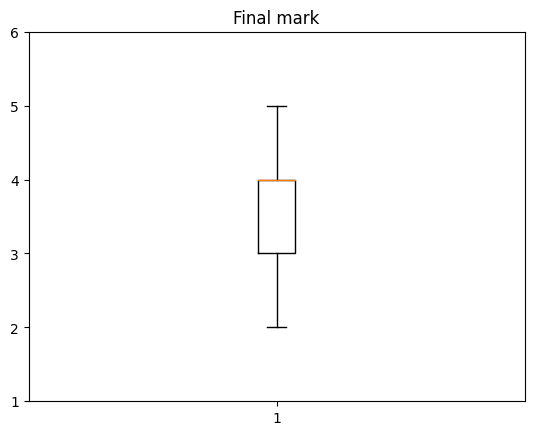

In [ ]:
g3_data = df_encoded.select("G3").collect()

plt.boxplot([x[0] for x in g3_data])
plt.title('Final mark')
plt.axis([0, 2, 1, 6])
plt.show()

In [ ]:
dftest = df_encoded.filter(df_encoded['age'] > 19)
dftest.show()

+---+---------+----+------+--------+--------+---+---+---+-----+-----+---------+---------+-----------+-----------+------------+----------+-------------+-----------+------------+------------+----------+-------------+-----------+------------+------------+-----------+-------------+-----------------+---------+------------+-----------+--------------+-----------+---------+------------+-----------+--------------+-----------+--------------+-------------------+-------------------+--------------+------------+-----------------+-----------------+-------------+------------+----------+-----------+-----------+----------------+--------------+------------+-------------+-------------+---------------+----------+--------+---------+---------+-----------+----------+--------+---------+---------+-----------+------------+----------+-----------+-----------+----------------+
|age|schoolsup|paid|higher|internet|absences| G1| G2| G3|sex_F|sex_M|address_U|address_R|famsize_LE3|famsize_GT3|Mjob_at_home|Mjob_other|Mjo

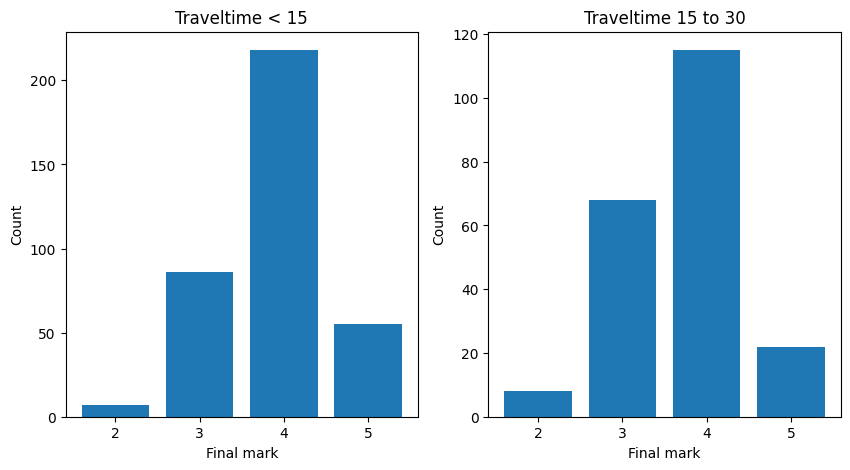

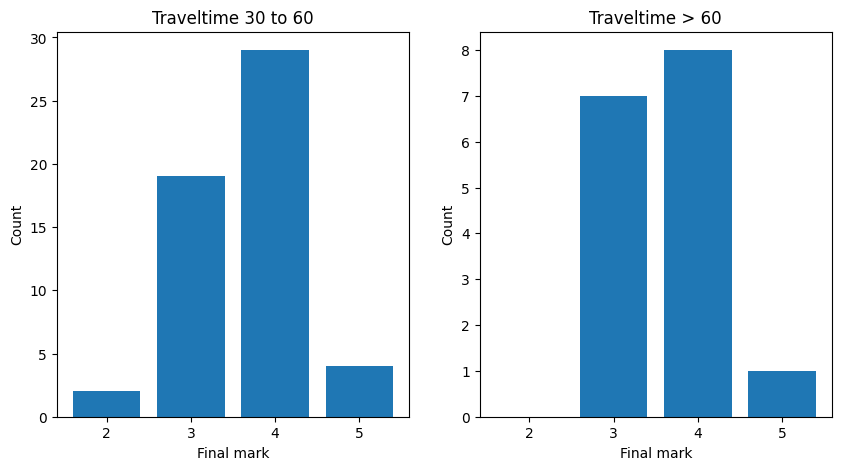

In [ ]:
traveltime_15 = df_encoded.filter(col("traveltime_<15") == 1).select("G3")
traveltime_15_to_30 = df_encoded.filter(col("traveltime_15_to_30") == 1).select("G3")
traveltime_30_to_60 = df_encoded.filter(col("traveltime_30_to_60") == 1).select("G3")
traveltime_60 = df_encoded.filter(col("traveltime_>60") == 1).select("G3")

# Создать гистограммы
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
traveltime_15.createOrReplaceTempView("traveltime_15")
plt.hist([x[0] for x in spark.sql("SELECT G3 FROM traveltime_15").collect()], bins=range(2, 7), align='left', rwidth=0.8)
plt.title('Traveltime < 15')
plt.xlabel('Final mark')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
traveltime_15_to_30.createOrReplaceTempView("traveltime_15_to_30")
plt.hist([x[0] for x in spark.sql("SELECT G3 FROM traveltime_15_to_30").collect()], bins=range(2, 7), align='left', rwidth=0.8)
plt.title('Traveltime 15 to 30')
plt.xlabel('Final mark')
plt.ylabel('Count')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
traveltime_30_to_60.createOrReplaceTempView("traveltime_30_to_60")
plt.hist([x[0] for x in spark.sql("SELECT G3 FROM traveltime_30_to_60").collect()], bins=range(2, 7), align='left', rwidth=0.8)
plt.title('Traveltime 30 to 60')
plt.xlabel('Final mark')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
traveltime_60.createOrReplaceTempView("traveltime_60")
plt.hist([x[0] for x in spark.sql("SELECT G3 FROM traveltime_60").collect()], bins=range(2, 7), align='left', rwidth=0.8)
plt.title('Traveltime > 60')
plt.xlabel('Final mark')
plt.ylabel('Count')

plt.show()

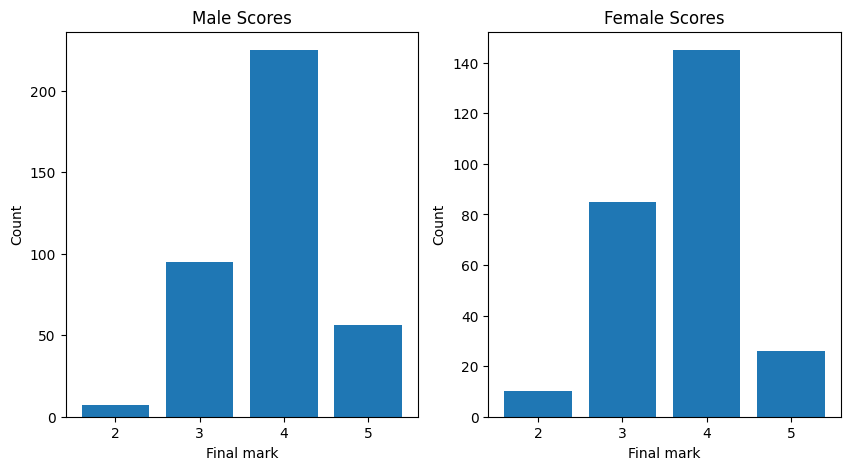

In [ ]:
male_scores = df_encoded.filter(col("sex_F") == 1).select("G3")
female_scores = df_encoded.filter(col("sex_M") == 1).select("G3")

# Создать гистограммы
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
male_scores.createOrReplaceTempView("male_scores")
plt.hist([x[0] for x in spark.sql("SELECT G3 FROM male_scores").collect()], bins=range(2, 7), align='left', rwidth=0.8)
plt.title('Male Scores')
plt.xlabel('Final mark')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
female_scores.createOrReplaceTempView("female_scores")
plt.hist([x[0] for x in spark.sql("SELECT G3 FROM female_scores").collect()], bins=range(2, 7), align='left', rwidth=0.8)
plt.title('Female Scores')
plt.xlabel('Final mark')
plt.ylabel('Count')

plt.show()

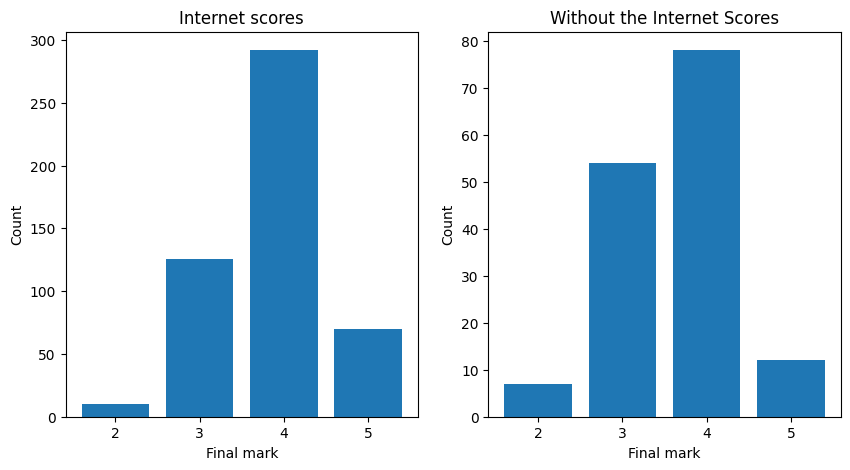

In [ ]:
internet_scores = df_encoded.filter(col("internet") == 1).select("G3")
without_internet_scores = df_encoded.filter(col("internet") == 0).select("G3")

# Создать гистограммы
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
internet_scores.createOrReplaceTempView("internet_scores")
plt.hist([x[0] for x in spark.sql("SELECT G3 FROM internet_scores").collect()], bins=range(2, 7), align='left', rwidth=0.8)
plt.title('Internet scores')
plt.xlabel('Final mark')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
without_internet_scores.createOrReplaceTempView("without_internet_scores")
plt.hist([x[0] for x in spark.sql("SELECT G3 FROM without_internet_scores").collect()], bins=range(2, 7), align='left', rwidth=0.8)
plt.title('Without the Internet Scores')
plt.xlabel('Final mark')
plt.ylabel('Count')

plt.show()

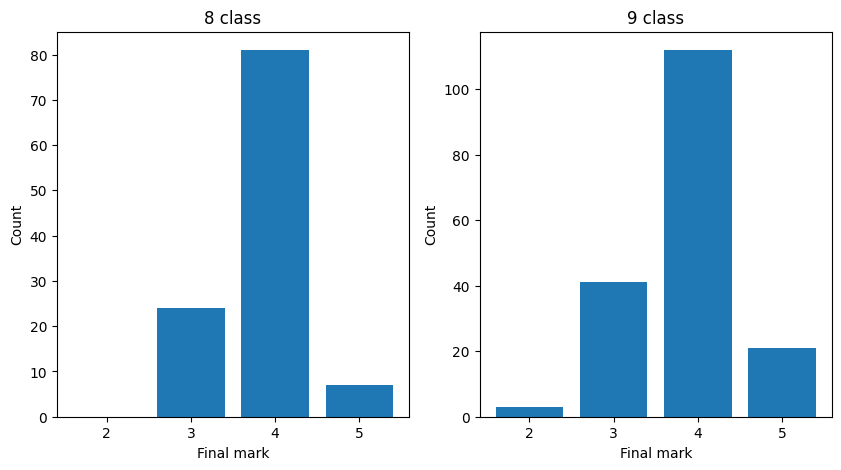

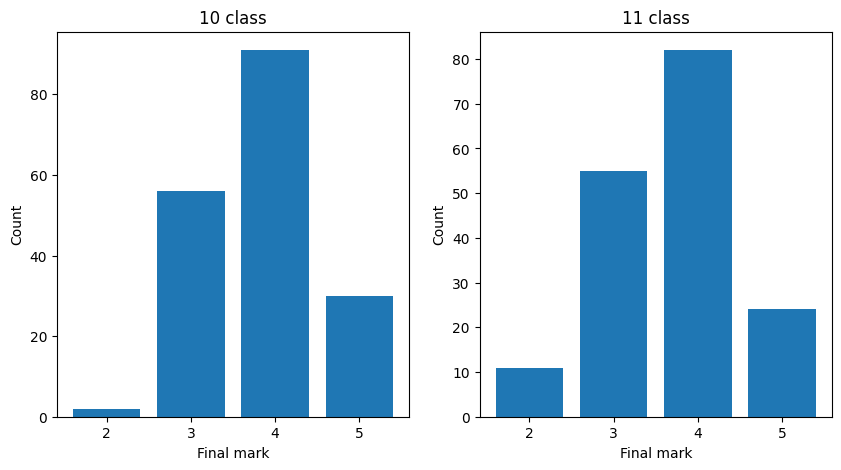

In [ ]:
traveltime_15 = df_encoded.filter(col("age") == 15).select("G3")
traveltime_15_to_30 = df_encoded.filter(col("age") == 16).select("G3")
traveltime_30_to_60 = df_encoded.filter(col("age") == 17).select("G3")
traveltime_60 = df_encoded.filter((col("age") == 18) | (col("age") == 19)).select("G3")

# Создать гистограммы
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
traveltime_15.createOrReplaceTempView("traveltime_15")
plt.hist([x[0] for x in spark.sql("SELECT G3 FROM traveltime_15").collect()], bins=range(2, 7), align='left', rwidth=0.8)
plt.title('8 class')
plt.xlabel('Final mark')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
traveltime_15_to_30.createOrReplaceTempView("traveltime_15_to_30")
plt.hist([x[0] for x in spark.sql("SELECT G3 FROM traveltime_15_to_30").collect()], bins=range(2, 7), align='left', rwidth=0.8)
plt.title('9 class')
plt.xlabel('Final mark')
plt.ylabel('Count')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
traveltime_30_to_60.createOrReplaceTempView("traveltime_30_to_60")
plt.hist([x[0] for x in spark.sql("SELECT G3 FROM traveltime_30_to_60").collect()], bins=range(2, 7), align='left', rwidth=0.8)
plt.title('10 class')
plt.xlabel('Final mark')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
traveltime_60.createOrReplaceTempView("traveltime_60")
plt.hist([x[0] for x in spark.sql("SELECT G3 FROM traveltime_60").collect()], bins=range(2, 7), align='left', rwidth=0.8)
plt.title('11 class')
plt.xlabel('Final mark')
plt.ylabel('Count')

plt.show()

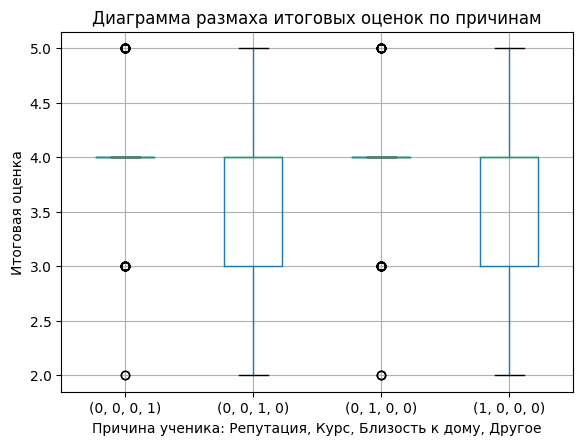

In [ ]:
reason_columns = ["reason_other", "reason_home", "reason_course", "reason_reputation"]

# Создание нового DataFrame с нужными столбцами
df_selected = df_encoded.select('G3', *reason_columns)

# Конвертация в Pandas DataFrame для визуализации
pandas_df = df_selected.toPandas()

# Создание диаграммы размаха
fig, ax = plt.subplots()
pandas_df.boxplot(column=['G3'], by=["reason_other", "reason_home", "reason_course", "reason_reputation"], ax=ax)
ax.set_xlabel('Причина ученика: Репутация, Курс, Близость к дому, Другое')
ax.set_ylabel('Итоговая оценка')
ax.set_title('Диаграмма размаха итоговых оценок по причинам')
plt.suptitle('') # Убираем стандартный заголовок
plt.show()

<Figure size 1000x600 with 0 Axes>

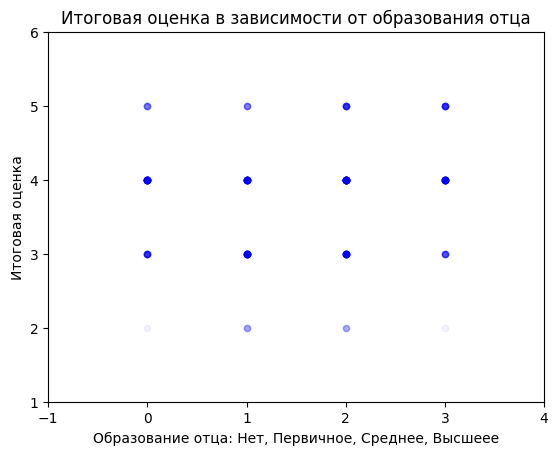

In [ ]:
dft = df_encoded

# Обновление DataFrame с биномиальными значениями
dft = dft.withColumn("Fedu_none", col("Fedu_none").cast("integer"))
dft = dft.withColumn("Fedu_primary", col("Fedu_primary").cast("integer"))
dft = dft.withColumn("Fedu_5_to_9", col("Fedu_5_to_9").cast("integer"))
dft = dft.withColumn("Fedu_higher", col("Fedu_higher").cast("integer"))

# Создание нового столбца 'Fedu' для удобства визуализации
dft = dft.withColumn("Fedu",
                   col("Fedu_none") * 0 +
                   col("Fedu_primary") * 1 +
                   col("Fedu_5_to_9") * 2 +
                   col("Fedu_higher") * 3)

# Выбор нужных столбцов
df_selected = dft.select('G3', 'Fedu')

# Конвертация в Pandas DataFrame для визуализации
pandas_df = df_selected.toPandas()

# Создание диаграммы рассеяния
plt.figure(figsize=(10, 6))
ax = pandas_df.plot(kind='scatter', x='Fedu', y='G3', c='blue', alpha=0.05)
ax.set_title('Итоговая оценка в зависимости от образования отца')
ax.set_xlabel('Образование отца: Нет, Первичное, Среднее, Высшеее')
ax.set_ylabel('Итоговая оценка')
plt.axis([-1, 4, 1, 6]) # Предполагаем, что оценки находятся в диапазоне от 0 до 20
plt.suptitle('')
plt.show()

<Figure size 1000x600 with 0 Axes>

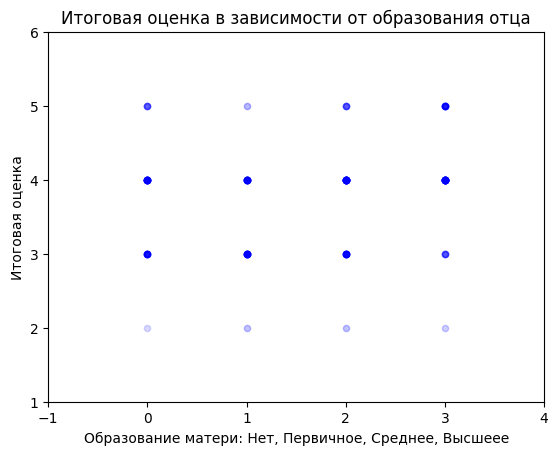

In [ ]:
dfte = df_encoded

# Обновление DataFrame с биномиальными значениями
dfte = dfte.withColumn("Medu_none", col("Medu_none").cast("integer"))
dfte = dfte.withColumn("Medu_primary", col("Medu_primary").cast("integer"))
dfte = dfte.withColumn("Medu_5_to_9", col("Medu_5_to_9").cast("integer"))
dfte = dfte.withColumn("Medu_higher", col("Medu_higher").cast("integer"))

# Создание нового столбца 'Fedu' для удобства визуализации
dfte = dfte.withColumn("Medu",
                   col("Medu_none") * 0 +
                   col("Medu_primary") * 1 +
                   col("Medu_5_to_9") * 2 +
                   col("Medu_higher") * 3)

# Выбор нужных столбцов
df_selected = dfte.select('G3', 'Medu')

# Конвертация в Pandas DataFrame для визуализации
pandas_df = df_selected.toPandas()

# Создание диаграммы рассеяния
plt.figure(figsize=(10, 6))
ax = pandas_df.plot(kind='scatter', x='Medu', y='G3', c='blue', alpha=0.05)
ax.set_title('Итоговая оценка в зависимости от образования отца')
ax.set_xlabel('Образование матери: Нет, Первичное, Среднее, Высшеее')
ax.set_ylabel('Итоговая оценка')
plt.axis([-1, 4, 1, 6]) # Предполагаем, что оценки находятся в диапазоне от 0 до 20
plt.suptitle('')
plt.show()

In [ ]:
dfpand1 = df_encoded.select('age','schoolsup','paid','higher','internet','absences','G1','G2', 'G3', 'sex_F').toPandas()
dfpand2 = df_encoded.select('sex_M','address_U','address_R','famsize_LE3','famsize_GT3','Mjob_at_home','Mjob_other','Mjob_services','Mjob_health','Mjob_teacher').toPandas()
dfpand3 = df_encoded.select('Fjob_at_home','Fjob_other','Fjob_services','Fjob_health','Fjob_teacher','reason_other','reason_home','reason_course','reason_reputation','Medu_none').toPandas()
dfpand4 = df_encoded.select('Medu_primary','Medu_5_to_9','Medu_secondary','Medu_higher','Fedu_none','Fedu_primary','Fedu_5_to_9','Fedu_secondary','Fedu_higher','traveltime_<15').toPandas()
dfpand5 = df_encoded.select('traveltime_15_to_30','traveltime_30_to_60','traveltime_>60','studytime_<2','studytimer_2_to_5','studytime_5_to_10','studytime_>10','famrel_v_bad','famrel_bad','famrel_cool').toPandas()
dfpand6 = df_encoded.select('famrel_good','famrel_excellent','freetime_v_low','freetime_low','freetime_cool','freetime_high','freetime_v_high','Dalc_v_low','Dalc_low','Dalc_cool').toPandas()
dfpand7 = df_encoded.select('Dalc_high','Dalc_v_high','Walc_v_low','Walc_low','Walc_cool','Walc_high','Walc_v_high','health_v_bad','health_bad','health_cool').toPandas()
dfpand8 = df_encoded.select('health_good','health_excellent').toPandas()

# Объединение DataFrame
df1_2 = pd.concat([dfpand1, dfpand2])

df1_2.corr()

,age,schoolsup,paid,higher,internet,absences,G1,G2,G3,sex_F,sex_M,address_U,address_R,famsize_LE3,famsize_GT3,Mjob_at_home,Mjob_other,Mjob_services,Mjob_health,Mjob_teacher
age,1.000000,-0.167841,-0.005458,-0.265497,0.013115,0.149998,-0.164200,-0.115043,-0.129214,0.043662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
schoolsup,-0.167841,1.000000,0.040512,0.085355,-0.025942,-0.059503,-0.077416,-0.041792,-0.060137,0.111202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
paid,-0.005458,0.040512,1.000000,0.024112,0.031823,-0.035959,-0.043126,-0.013123,-0.029102,-0.079300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
higher,-0.265497,0.085355,0.024112,1.000000,0.070345,-0.129891,0.323233,0.318820,0.321567,0.058134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
internet,0.013115,-0.025942,0.031823,0.070345,1.000000,0.067301,0.124262,0.139212,0.134929,-0.065911,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
absences,0.149998,-0.059503,-0.035959,-0.129891,0.067301,1.000000,-0.151008,-0.121563,-0.116657,-0.021336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
G1,-0.164200,-0.077416,-0.043126,0.323233,0.124262,-0.151008,1.000000,0.746882,0.726131,0.107161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
G2,-0.115043,-0.041792,-0.013123,0.318820,0.139212,-0.121563,0.746882,1.000000,0.825440,0.097512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
G3,-0.129214,-0.060137,-0.029102,0.321567,0.134929,-0.116657,0.726131,0.825440,1.000000,0.114136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sex_F,0.043662,0.111202,-0.079300,0.058134,-0.065911,-0.021336,0.107161,0.097512,0.114136,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
dftest_g3 = df_encoded
dftest_g3 = dftest_g3.filter(col('G3') == 2)

mean_values = dftest_g3.select([mean(c).alias(c) for c in dftest_g3.columns]).collect()[0].asDict()

# Выводим результат
for col, mean_value in mean_values.items():
    print(f" '{col}': {mean_value}")

 'age': 17.941176470588236
 'schoolsup': 0.058823529411764705
 'paid': 0.058823529411764705
 'higher': 0.6470588235294118
 'internet': 0.5882352941176471
 'absences': 0.7058823529411765
 'G1': 2.823529411764706
 'G2': 2.5294117647058822
 'G3': 2.0
 'sex_F': 0.4117647058823529
 'sex_M': 0.5882352941176471
 'address_U': 0.4117647058823529
 'address_R': 0.0
 'famsize_LE3': 0.11764705882352941
 'famsize_GT3': 0.8823529411764706
 'Mjob_at_home': 0.23529411764705882
 'Mjob_other': 0.5294117647058824
 'Mjob_services': 0.11764705882352941
 'Mjob_health': 0.0
 'Mjob_teacher': 0.11764705882352941
 'Fjob_at_home': 0.058823529411764705
 'Fjob_other': 0.47058823529411764
 'Fjob_services': 0.4117647058823529
 'Fjob_health': 0.0
 'Fjob_teacher': 0.058823529411764705
 'reason_other': 0.35294117647058826
 'reason_home': 0.17647058823529413
 'reason_course': 0.35294117647058826
 'reason_reputation': 0.11764705882352941
 'Medu_none': 0.0
 'Medu_primary': 0.29411764705882354
 'Medu_5_to_9': 0.294117647058